In [2]:
%load_ext watermark
%watermark -v -a "author: eli knaap" -d -u -p geopandas,geosnap

/Users/knaaptime/Dropbox/projects/geosnap/geosnap/_data.py:66: UserWarning: The geosnap data storage class is provided for convenience only. The geosnap developers make no promises regarding data quality, consistency, or availability, nor are they responsible for any use/misuse of the data. The end-user is responsible for any and all analyses or applications created with the package.
  warn(
/Users/knaaptime/Dropbox/projects/geosnap/geosnap/_data.py:66: UserWarning: The geosnap data storage class is provided for convenience only. The geosnap developers make no promises regarding data quality, consistency, or availability, nor are they responsible for any use/misuse of the data. The end-user is responsible for any and all analyses or applications created with the package.
  warn(


Author: author: eli knaap

Last updated: 2023-01-03

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.2.0

geopandas: 0.10.2
geosnap  : 0.11.0+6.gafdff09e3ff1.dirty



In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from geosnap import DataStore
from geosnap.io import get_acs
from geosnap.analyze import cluster, regionalize, find_k, find_region_k

In [5]:
import geopandas as gpd

In [6]:
store = DataStore()

/Users/knaaptime/Dropbox/projects/geosnap/geosnap/_data.py:66: UserWarning: The geosnap data storage class is provided for convenience only. The geosnap developers make no promises regarding data quality, consistency, or availability, nor are they responsible for any use/misuse of the data. The end-user is responsible for any and all analyses or applications created with the package.
  warn(


# Assessing Cluster Fit

In [7]:
chicago = get_acs(
    store, county_fips="17031", level="tract", years=list(range(2013, 2018))
)  # without specifying a subset of years, we get everything

In [8]:
columns = [
    "median_household_income",
    "median_home_value",
    "p_asian_persons",
    "p_hispanic_persons",
    "p_nonhisp_black_persons",
    "p_nonhisp_white_persons",
]

Scikit learn [provides several measures](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) for assessing the fit of a cluster model. When ground-trouth is unknown (such as the case of geodemographics), three measures, in particlar, are appropriate:

- the silhouette score
- the Calinski-Harabasz score
- the Davies Bouldin_score

## Comparing clustering algorithms

Using the same input data, here are two different geodemographic cluster results, one using kmeans, the other using hierarchical clustering with ward's linkage.

In [9]:
test, mod = cluster(
    chicago, columns=columns, method="kmeans", n_clusters=6, return_model=True
)

In [10]:
test_ward, mod_ward = cluster(
    chicago, columns=columns, method="ward", n_clusters=6, return_model=True
)

The `ModelResults` class returned by the cluster function provides fit measures for each solution as properties

### Silhouette Score (higher is better)

In [11]:
mod.silhouette_score

0.4098185798706116

In [12]:
mod_ward.silhouette_score

0.3533587226197327

### Calinski-Harabasz score (higher is better)

In [13]:
mod.calinski_harabasz_score

4695.28865092832

In [14]:
mod_ward.calinski_harabasz_score

3841.9252886288127

### Davies Bouldin score (lower is better)

In [15]:
mod.davies_bouldin_score

0.9525929559242593

In [16]:
mod_ward.davies_bouldin_score

0.9418395695489395

The silhouette and Calinski-Harabasz scores suggest the kmeans model discovers clusters with better separation than hierarchical clustering for these data, but the Davies-Bouldin score is ever so mildly in favor of hierarchical clustering

## Choosing `k` (the number of clusters)

To help choose the an appropriate number of clusters, 

### Clustering

In [17]:
ks = find_k(
    chicago,
    columns=columns,
    method="kmeans",
    max_k=15,
)

  0%|          | 0/14 [00:00<?, ?it/s]

In [18]:
ks

,best_k
silhouette_score,5
calinski_harabasz_score,5
davies_bouldin_score,3


In [19]:
ks_ward = find_k(chicago, columns=columns, method="ward", max_k=15)

  0%|          | 0/14 [00:00<?, ?it/s]

In [20]:
ks_ward

,best_k
silhouette_score,4
calinski_harabasz_score,5
davies_bouldin_score,3


In [14]:
ks = find_k(
    chicago, columns=columns, method="kmeans", min_k=10, max_k=25, return_table=True
)

  0%|          | 0/16 [00:00<?, ?it/s]

passing the argument `return_table=True` will return the full table of fit metrics indexed by $k$

In [ ]:
ks.head()

In [8]:
import matplotlib.pyplot as plt

Plotting each measure on the y-axis, and $k$ on the x-axis shows how the fit metric changes as the number of clusters increases

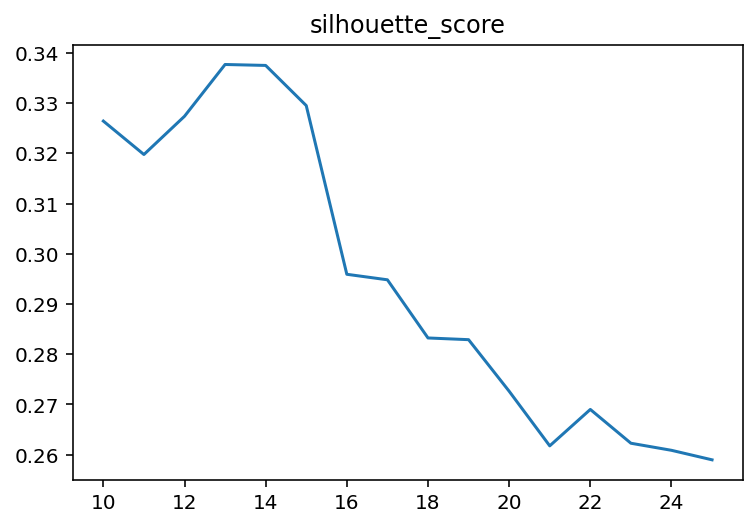

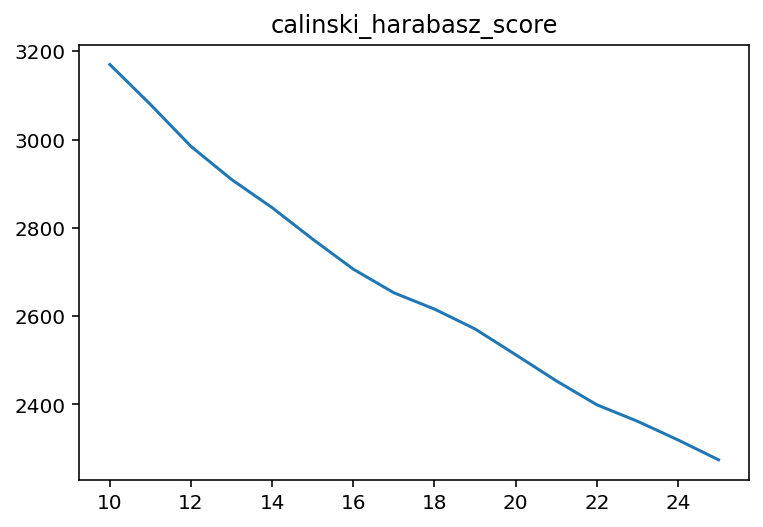

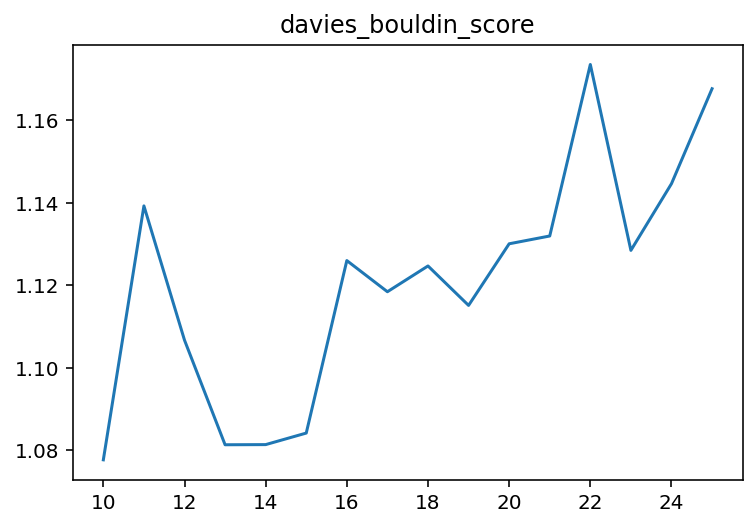

In [15]:
for i in ks.columns:
    f, ax = plt.subplots()
    ks[i].plot(title=i)

In this case 13 clusters or so looks appropriate

### Regionalization

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
test_ward_spatial, mod_ward_spatial = regionalize(
    chicago,
    columns=columns,
    method="ward_spatial",
    n_clusters=6,
    return_model=True,
    scaler=MinMaxScaler(),
)

In [23]:
mod_ward_spatial[2013].boundary_silhouette.boundary_silhouette.mean()

0.02078115711693032

<AxesSubplot:>

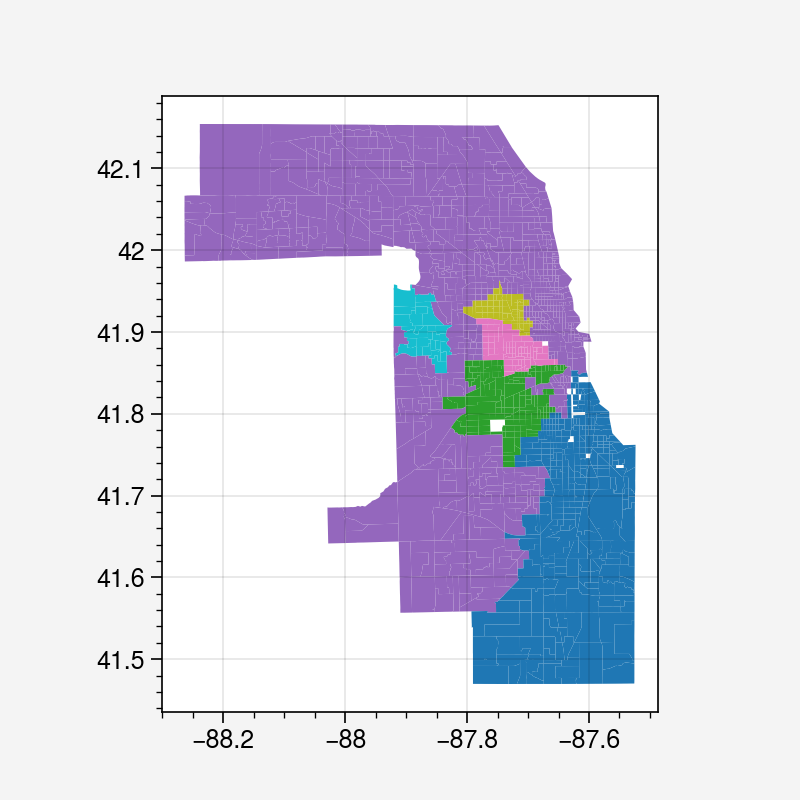

In [117]:
test_ward_spatial[test_ward_spatial.year==2017].plot('ward_spatial')

In [42]:
from geosnap.visualize import plot_timeseries

SubplotGrid(nrows=1, ncols=4, length=4)

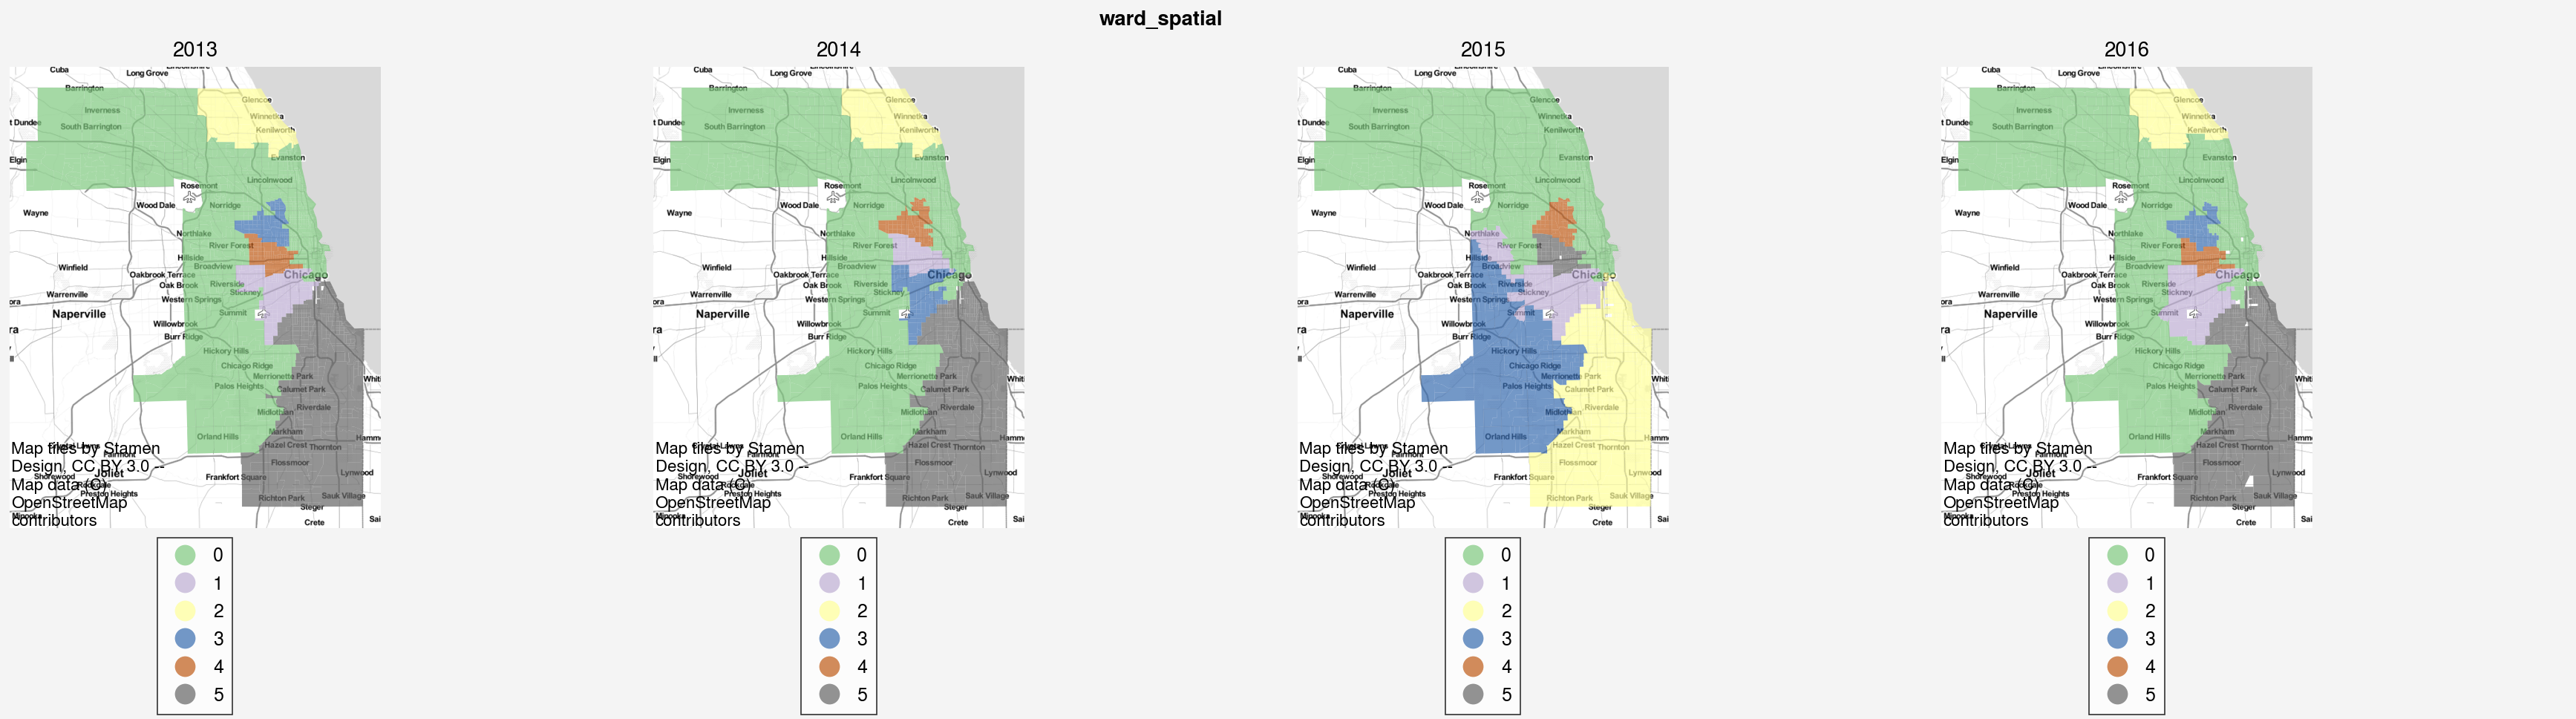

In [43]:
plot_timeseries(test_ward_spatial, 'ward_spatial', categorical=True)

An analogous function is provided for determining the best number of $k$ regions according to each metric

In [20]:
reg_k = find_region_k(
    chicago, columns=columns, method="ward_spatial", min_k=5, max_k=20
)

  0%|          | 0/16 [00:00<?, ?it/s]

We might use this to examine whether a region is getting more integrated over time. For example if the best fitting $k$ is increasing over time, then it suggests an increasingly-complex grouping structure is necessary to describe the study area. Put differently, this would suggest the emergence of "new neighborhoods" and the need to cut the region into a greater number of homogenous places.

In [21]:
reg_k

,silhouette_score,calinski_harabasz_score,path_silhouette,boundary_silhouette,davies_bouldin_score
time_period,,,,,
2013.0,5.0,9.0,20.0,20.0,6.0
2014.0,10.0,8.0,13.0,19.0,6.0
2015.0,5.0,10.0,20.0,20.0,5.0
2016.0,5.0,8.0,20.0,19.0,6.0
2017.0,8.0,8.0,18.0,16.0,6.0


Using a sequence of the 5-year ACS in Chicagoland, things look pretty stable (and small--only two regions get the "best" metric in all cases)

And by passing `return_model=True`, we again get back the full table of fit metrics. We can use this table, for example, to compare the difference between using the standard (z-score) scaler versus a min-max scaler, often used in non-geodemographic clustering applications

In [31]:
chicago  = chicago[chicago.year==2017]

In [34]:
# StandardScaler is the default
ktab = find_region_k(
    chicago,
    columns=columns,
    method="ward_spatial",
    return_table=True,
    min_k=5,
    max_k=50,
)

  0%|          | 0/46 [00:00<?, ?it/s]

In [40]:
ktab_minmax = find_region_k(
    chicago,
    columns=columns,
    method="ward_spatial",
    return_table=True,
    min_k=5,
    max_k=50,
    scaler=MinMaxScaler() # here we swap in the min-max scaler,
)

  0%|          | 0/46 [00:00<?, ?it/s]

In [ ]:
import seaborn as sns

<AxesSubplot:xlabel='k'>

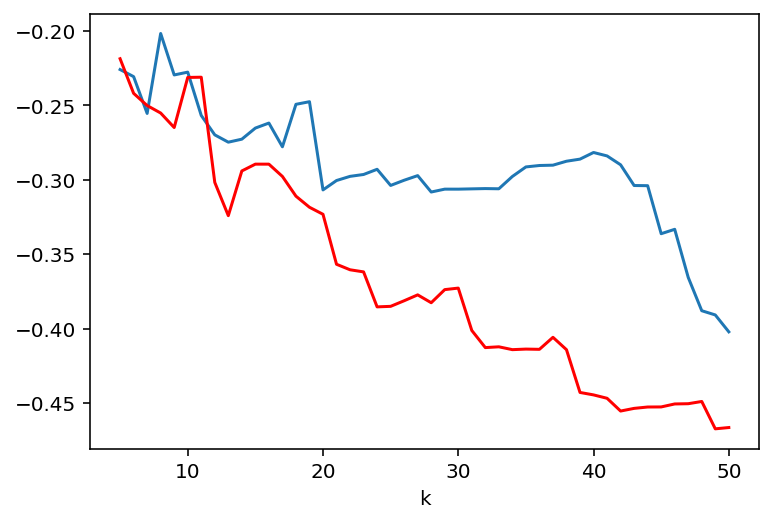

In [41]:
ax =ktab.silhouette_score.plot()
ktab_minmax.silhouette_score.plot(ax=ax, c='red')

I think those local maxima look interesting (e.g. around 18 and around 40 in the blue graph). Before those, there is a steady score increase, so these might be different natural cut points in the neighborhood structure

it also looks like the standard scaler outperforms the minmax scaler at just about every level of $k$

<AxesSubplot:xlabel='k'>

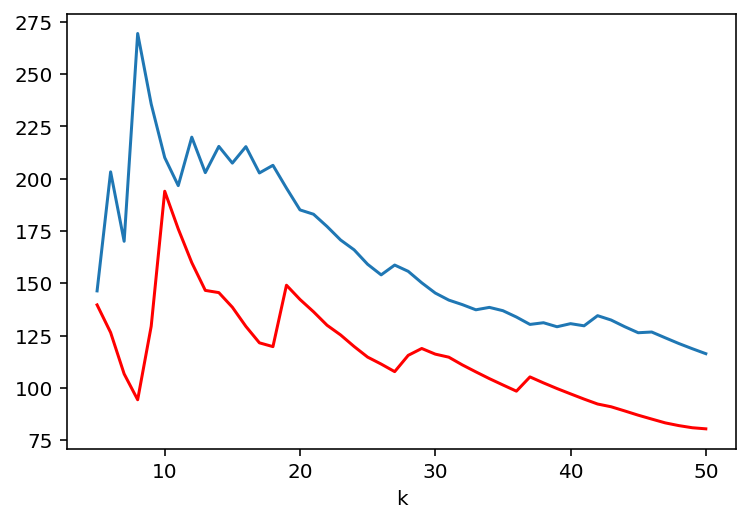

In [42]:
ax = ktab.calinski_harabasz_score.plot()
ktab_minmax.calinski_harabasz_score.plot(ax=ax, c='red')

<AxesSubplot:xlabel='k'>

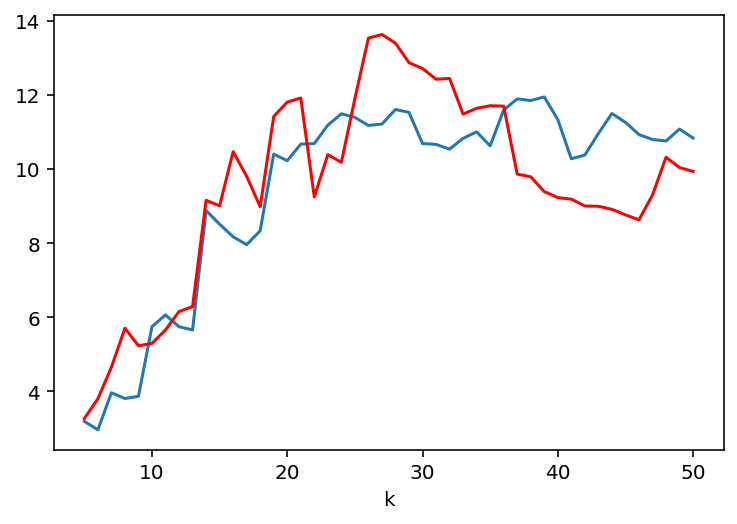

In [43]:
ax = ktab.davies_bouldin_score.plot()
ktab_minmax.davies_bouldin_score.plot(ax=ax, c='red')
# lower is better here

### Spatial Fit Measures

>Overall, silhouette statistics are useful in the analysis of clustering and similarity. However, in geographical applications, it sometimes becomes important to understand the geographical structure of groups, in addition to the feature structure explored by silhouette statistics. So, two new silhouette statistics are proposed in Wolf, Knaap, and Rey (2019):
>
>1. The path silhouette, which measures the joint feature & geographical similarity.
>
>2. The boundary silhouette, which measures the similarity of boundaries between groups.
>
>Both have distinct uses, and do not supersede the silhouette statistic. Rather, they are spatial complements that provide different information about the geographical structure of groups in clustering problems.

Importantly, the regionalizers have two additional fit metrics ([geosilhouettes](https://pysal.org/esda/notebooks/geosilhouettes.html)) reflecting the fact that these algorithms are attempting to maximize spatial and attribute homogeneity. This is important, since, although you can use classic measures of cluster fit like a silhouette score to evaluate a regionalized solution, it will be severely penalized for grouping together dissimilar atoms, despite being *forced* to do so by virtue of the spatial constraint. 

Here, higher scores indicate regionalization solutions that find better demarcators of homogenous zones. Put differently, the better (higher) the score, the stronger the boundary between adjacent zones.

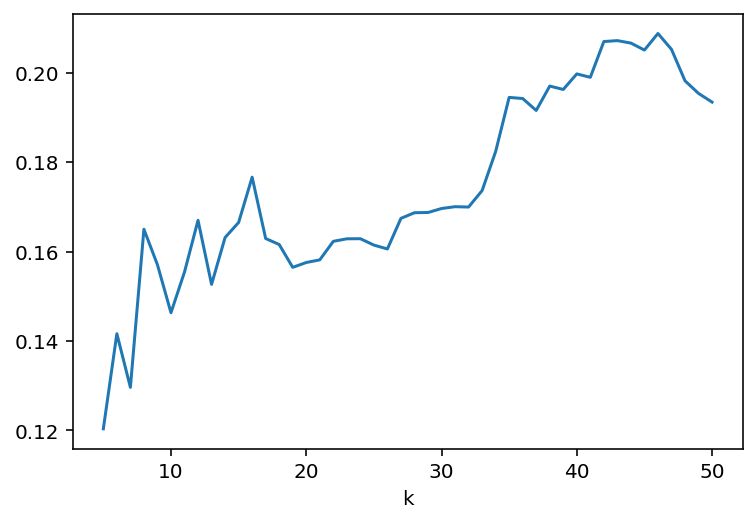

In [44]:
ax = ktab.boundary_silhouette.plot()
#t_table2.boundary_silhouette.plot(ax=ax, c='red')

In [45]:
ktab.boundary_silhouette.idxmax()

46.0

46 regions/neighborhoods provides the best model fit according to the boundary silhouette

by finding the `k` parameter that maximizes the boundary geosilhouette, we're searching for the best regionalization solution, where "best" means that the neighborhood/region is socio-deomographically homogenous, and the boundary lines that demarcate neighborhoods from one another divide between zones that are the most distinct. That is, by optimizing on the boundary silhouette, we're looking for the neighborhoods with the sharpest boundaries between different homogenous groups. 

This will tend to favor smaller groups whose multivariate homogeneity differentiates them strongly from adjacent groups/regions/neighborhoods 

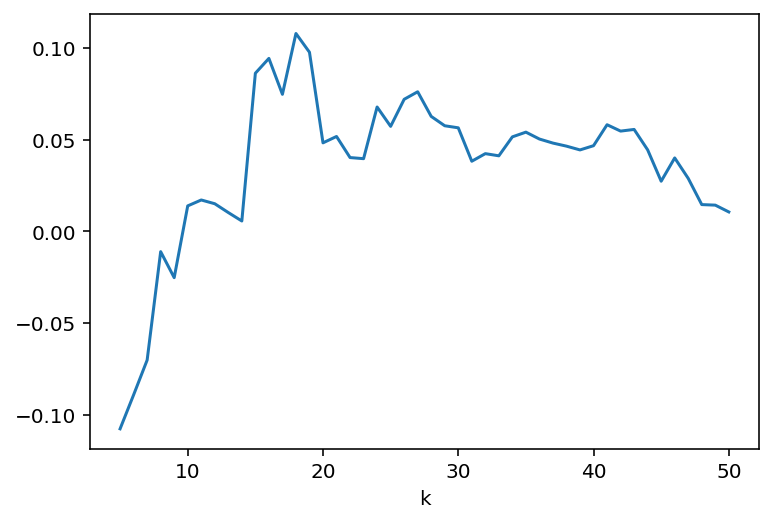

In [48]:
ax = ktab.path_silhouette.plot()

In [47]:
ktab.path_silhouette.idxmax()

18.0

18 regions/neighborhoods provides the best model fit according to the path silhouette

With the path geosilhouette, we're searching for the model that jointly optimizes the spatial and attribute homogeneity of input observations. In one sense, that means we want to group together observations that have high spatial autocorrelation along *each* of the input variables. That is, we want to form groups where the spatial lag of each observation is similar to the focal variable (in multivariate space)

This will tend to favor fewer regions/neighborhoods (though still more than the generic aspatial silhouette score


In the context of regionalization, choosing the `k` parameter that maximizes the boundary or path geosilhouette means means we are searching for groupings defined by different objectives. 

arguably, optimizing on *boundaries* means we are optimizing on distinctions in the region/neighborhood's perimeter, whereas optimizing on *paths* means we are optimizing on distinctions between the region/neighborhood cores. 

In [50]:
reg_k_kmeans = find_region_k(
    chicago, columns=columns, method="kmeans_spatial", min_k=5, max_k=100, return_table=True
)

  0%|          | 0/96 [00:00<?, ?it/s]

<AxesSubplot:xlabel='k'>

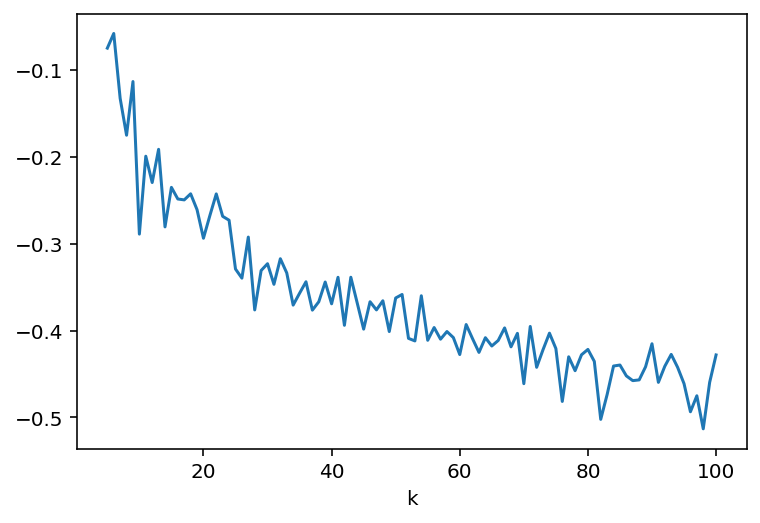

In [52]:
reg_k_kmeans.silhouette_score.plot()

<AxesSubplot:xlabel='k'>

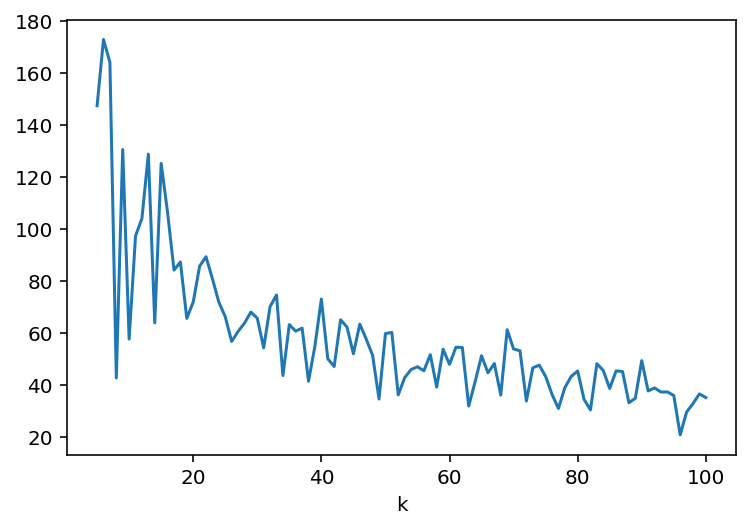

In [53]:
reg_k_kmeans.calinski_harabasz_score.plot()

<AxesSubplot:xlabel='k'>

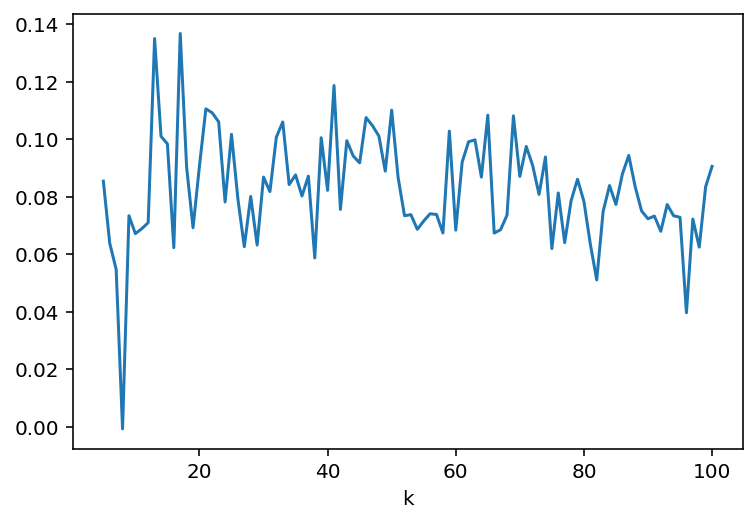

In [54]:
reg_k_kmeans.boundary_silhouette.plot()

<AxesSubplot:xlabel='k'>

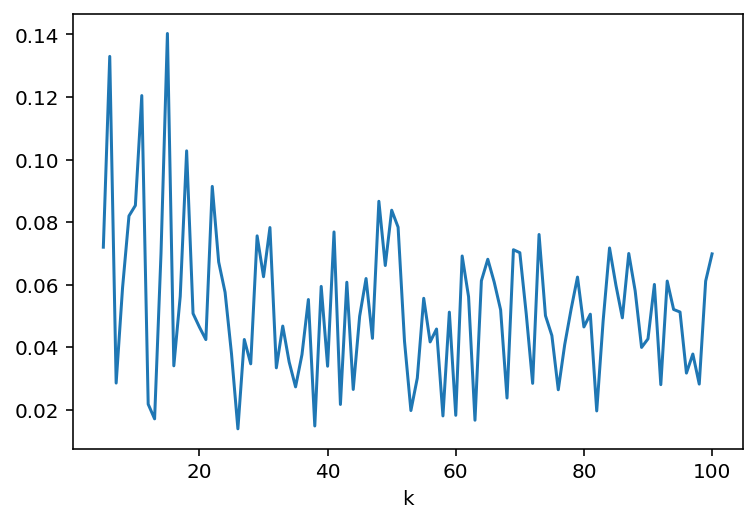

In [56]:
reg_k_kmeans.path_silhouette.plot()